# Strategy Details
This strategy is based on the followin paper:  Klaus Grobys, Veda Fatmy and Topias Rajalin, Combining low-volatility and momentum: recent evidence from the Nordic equities, Applied Economics, 2024
The idea is that: Low volatility anomaly can be combined with the momentum anomaly to enhance risk-adjusted returns.

The research on combined low-volatility and momentum investment strategies has primarily focused on the Nordic stock markets. However, it would be valuable to explore whether these combined strategies can also improve the performance of a pure-play momentum strategy in the context of the S&P 500.

In [1]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content

df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()

In [2]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        if len(df) > 3*252:
            holder.append(df)
            ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)
GEV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SOLV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800


Loaded data for 495 companies


In [3]:
# Get the monthly data as we use the monthly data to calculate the momentum
monthly_data = []
for data in holder:
    df = data.resample('M').agg({
        'date': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    df.set_index('date', inplace=True)

    # convert the date time to year-month
    df.index = df.index.to_period('M')

    monthly_data.append(df)


## Add the monthly returns and the volatilties

Assume we will open at the monthly open price and will close at the monthly close.

In [4]:
# Calculate the monthly returns
temp = []
for df in monthly_data:
    df['intra_month_return'] = df['Close'] / df['Open'] - 1
    df['next_intra_month_return'] = df['intra_month_return'].shift(-1)
    df['monthly_return'] = df['Close'].pct_change()
    
    # Last 12 months return except the current month
    df['rolling_12_months_return'] = df['monthly_return'].rolling(11).sum().shift()

    temp.append(df)

monthly_data = temp

In the research paper, weekly data are used to calculated the volatility. Here, we use daily returns to calculate the standard deviation of 3 years historical data

In [5]:
# Calculate the volatility using historical data of the last 3 years
for df in holder:
    df['daily_return'] = df['Close'].pct_change()
    df['rolling_3_years_volatility'] =df['daily_return'].rolling(3*252).std()
    df['last_month_rolling_3_years_volatility'] = df['rolling_3_years_volatility'].shift()

monthly_3_years_volatility_data = []
for df in holder:
    temp = df.copy()
    temp = temp.resample('M').agg({'date': 'first','last_month_rolling_3_years_volatility': 'first'})
    temp.set_index('date', inplace=True)
    temp.dropna(inplace=True)
    # Convert the date time to year-month format
    temp.index = temp.index.to_period('M')
    monthly_3_years_volatility_data.append(temp)

In [6]:
# Add the last_month_rolling_3_years_volatilityto monthly data
for i in range(len(monthly_data)):
    monthly_data[i] = pd.concat([monthly_data[i], monthly_3_years_volatility_data[i]], axis=1)

    #The backtesting period start from 2008-01-02
    monthly_data[i] = monthly_data[i].loc['2008-01-01':]

## Strategy Implementation

Firstly, convert the dataframes into a new dataframe with column names being tickers and row index being the datetime.

In [7]:
rolling_12_months_return_holder = []
next_intra_month_return_holder = []
last_month_rolling_3_years_std_holder = []
intra_month_reutrn_holder = []

# Creating tables with symbols as columns and the date as rows
for symbol, df in zip(tickers, monthly_data):

    rolling_12_months_return_series = df['rolling_12_months_return'].copy()
    next_intra_month_return_series = df['next_intra_month_return'].copy()
    last_month_rolling_3_years_std_series = df['last_month_rolling_3_years_volatility'].copy()
    
    rolling_12_months_return_series.name = symbol
    next_intra_month_return_series.name = symbol
    last_month_rolling_3_years_std_series.name = symbol

    rolling_12_months_return_holder.append(rolling_12_months_return_series)
    next_intra_month_return_holder.append(next_intra_month_return_series)
    last_month_rolling_3_years_std_holder.append(last_month_rolling_3_years_std_series)
  
# Create the final dataframes 
rolling_12_months_return_df = pd.concat(rolling_12_months_return_holder, axis=1, ignore_index=False)
next_intra_month_return_df = pd.concat(next_intra_month_return_holder, axis=1, ignore_index=False)
last_month_rolling_3_years_std_df = pd.concat(last_month_rolling_3_years_std_holder, axis=1, ignore_index=False)


print (rolling_12_months_return_df.iloc[:3, :4])
print (next_intra_month_return_df.iloc[:3, :4])
print (last_month_rolling_3_years_std_df.iloc[:3, :4])


              MMM       AOS       ABT  ABBV
date                                       
2008-01  0.165248 -0.037589  0.081723   NaN
2008-02  0.105294 -0.041811  0.057131   NaN
2008-03  0.065304  0.010470 -0.011287   NaN
              MMM       AOS       ABT  ABBV
date                                       
2008-01 -0.010007  0.037006 -0.055389   NaN
2008-02  0.012667 -0.094490  0.033352   NaN
2008-03 -0.034041 -0.069337 -0.037960   NaN
              MMM       AOS       ABT  ABBV
date                                       
2008-01  0.011269  0.021270  0.011481   NaN
2008-02  0.011350  0.021901  0.011652   NaN
2008-03  0.011437  0.022053  0.011725   NaN


In [8]:
# Build a table to store the results from 4 portfolios using portfolio name as rows and metrics as columns
columns = ['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'VaR']
index = ['High Momentum Portfolio', 'Low Volatility Portfolio', 'High Momentum First Low Volatility Portfolio', 'Low Volatility First High Momentum Portfolio']
results_df = pd.DataFrame(index=index, columns=columns)

### Pure-play High Momentum Portfolio

To build a pure-play high mometum portfolio, first, calculate a momentum score for each stock based on its recent 12 month returns exculding the nearest month. Then, identify the stocks with the highest momentum scores. Construct the portfolio by taking a long position in the high momentum stocks. 
Rebalance the portfolio monthly by recalculating the momentum scores and adjusting the long positions accordingly. 

In [9]:
# Get the high momentum stocks based on the rolling 12 months return
pure_high_momentum_df = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
pure_high_momentum_df.iloc[:, :] = np.nan

N = len(tickers) // 2
high_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=False) <= N

pure_high_momentum_df[high_momentum_mask] = 1

returns_df_for_pure_high_momentum = next_intra_month_return_df [high_momentum_mask]

equal_weight_portfolio_pure_high_momentum = returns_df_for_pure_high_momentum.mean(axis=1).shift()


The accumulative return of the high momentum portfolio is: 6.619423594210827
The annualized return of the high momentum portfolio is: 0.12538535917049032
The annualized volatility of the high momentum portfolio is: 0.16916506631800504
The Sharpe ratio of the high momentum portfolio is: 0.7412012533059549
The VaR at 95% confidence level of the high momentum portfolio is: -0.08084419975535029


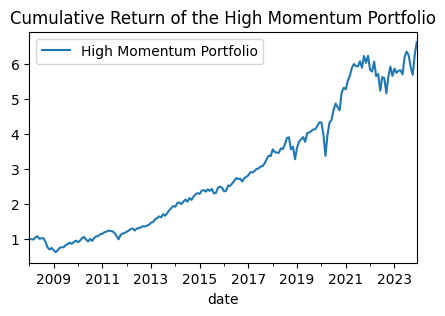

In [10]:
# calculate the cumulative return
cumulative_return_high_momentum = (1 + equal_weight_portfolio_pure_high_momentum).cumprod()
print("The accumulative return of the high momentum portfolio is:", cumulative_return_high_momentum[-1])

# Calculate the annualized return
annualized_return_high_momentum = cumulative_return_high_momentum[-1] ** (12 / len(cumulative_return_high_momentum)) - 1
print("The annualized return of the high momentum portfolio is:", annualized_return_high_momentum)

# Calculate the annualized volatility
annualized_volatility_high_momentum = equal_weight_portfolio_pure_high_momentum.std() * np.sqrt(12)
print("The annualized volatility of the high momentum portfolio is:", annualized_volatility_high_momentum)

# Calculate the Sharpe ratio
sharpe_ratio_high_momentum = annualized_return_high_momentum / annualized_volatility_high_momentum
print("The Sharpe ratio of the high momentum portfolio is:", sharpe_ratio_high_momentum)

# Calculate the VaR at 95% confidence level
VaR_95_high_momentum = equal_weight_portfolio_pure_high_momentum.quantile(0.05)
print("The VaR at 95% confidence level of the high momentum portfolio is:", VaR_95_high_momentum)

# Store the results in the results table
results_df.loc['High Momentum Portfolio', 'Total Return'] = cumulative_return_high_momentum[-1]
results_df.loc['High Momentum Portfolio', 'Annualized Return'] = annualized_return_high_momentum
results_df.loc['High Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility_high_momentum
results_df.loc['High Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio_high_momentum
results_df.loc['High Momentum Portfolio', 'VaR'] = VaR_95_high_momentum

# Plot the cumulative return of the high momentum portfolio
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
cumulative_return_high_momentum.plot(label='High Momentum Portfolio')
plt.title('Cumulative Return of the High Momentum Portfolio')
plt.legend()
plt.show()


### Pure Low-Volatility Portfolios

Similar to pure high momentum portfolio, but this time returns are only obtained by taking short position on low volatility stocks 

The accumulative return of the low volatility portfolio is: 5.254434565249174
The Sharpe ratio of the low volatility portfolio is: 0.767549091006001
The annualized volatility of the low volatility portfolio is: 0.15139769967240854
The annualized return of the low volatility portfolio is: 0.11695342935756736
The VaR of the low volatility portfolio is: -0.06717084992194747


<Axes: title={'center': 'Pure Low Volatility Portfolio Accumulative Return'}, xlabel='date'>

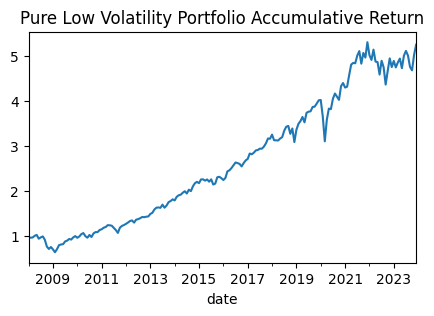

In [11]:
# Get the high momentum and low momentum stocks based on the rolling 3 years volatility
pure_low_volatility_df = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
pure_low_volatility_df.iloc[:, :] = np.nan

N = len(tickers) // 2
low_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=True) <= N

pure_low_volatility_df[low_volatility_mask] = 1

returns_df_for_pure_low_volatility = next_intra_month_return_df[low_volatility_mask]

equal_weight_portfolio_pure_low_volatility = returns_df_for_pure_low_volatility.mean(axis=1).shift()

# calculate the cumulative return
cumulative_return_low_volatility = (1 + equal_weight_portfolio_pure_low_volatility).cumprod()
print("The accumulative return of the low volatility portfolio is:", cumulative_return_low_volatility[-1])

# Calculate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_pure_low_volatility.mean() / equal_weight_portfolio_pure_low_volatility.std()* np.sqrt(12)
print("The Sharpe ratio of the low volatility portfolio is:", sharpe_ratio)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_pure_low_volatility.std() * np.sqrt(12)
print("The annualized volatility of the low volatility portfolio is:", annualized_volatility)

# Calculate the annualized return
annualized_return = (cumulative_return_low_volatility[-1]) ** (1/15) - 1
print("The annualized return of the low volatility portfolio is:", annualized_return)

# Calculate the VaR
VaR = equal_weight_portfolio_pure_low_volatility.quantile(0.05)
print("The VaR of the low volatility portfolio is:", VaR)

# Store the results in the results table
results_df.loc['Low Volatility Portfolio', 'Total Return'] = cumulative_return_low_volatility[-1]
results_df.loc['Low Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Low Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Low Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Low Volatility Portfolio', 'VaR'] = VaR

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return_low_volatility.plot(title='Pure Low Volatility Portfolio Accumulative Return')


### Double Screening: Combined Strategy

combination portfolios are created by double-screening stocks by volatility and momentum, and using both volatility-first and momentum-first sorting. For example, in the volatility-first double-screened combination portfolio, stocks are first sorted into two halves by volatility, and then by momentum. This process generates the high momentum stocks from the low volatility universe. This allocation procedure is repeated vice versa for the momentum-first dobble-screened combination portfolios.

#### 1. Low-Volatility Stocks from High Momentum Universe

We first perform momentum first combined strategy

In [12]:
HighMomentumFirst_LowVolatility_df = pd.DataFrame(index = rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
HighMomentumFirst_LowVolatility_df.iloc[:, :] = np.nan

# Copy the rolling 12 months return dataframe to avoid changing the original dataframe
rolling_12_months_return_df_copy = rolling_12_months_return_df.copy()

# Firstly selecte the high momentum stocks
N_high_momentum = len(tickers) // 2
high_momentum_mask =rolling_12_months_return_df_copy.rank(axis=1, method='dense', ascending=False) <= N_high_momentum
HighMomentumFirst_LowVolatility_df[high_momentum_mask] = 1

# Set the low momentum stocks to be nan so that we can only select the high momentum stocks
rolling_12_months_return_df_copy[~high_momentum_mask] = np.nan

# Select the low volatility stocks from the high momentum stocks

# Set the number of low volatility stocks to be half of the high momentum stocks number
N_low_volatility = N_high_momentum // 2
low_volatility_mask = rolling_12_months_return_df_copy.rank(axis=1, method='dense', ascending=True) <= N_low_volatility
# Denote the low volatility stocks to be 1 and the high volatility stocks to be nan
HighMomentumFirst_LowVolatility_df[low_volatility_mask] = 1
HighMomentumFirst_LowVolatility_df[~low_volatility_mask] = np.nan

# Copy the next intra month return dataframe to avoid changing the original dataframe
next_intra_month_return_df_copy = next_intra_month_return_df.copy()

returns_df_for_high_momentumFirst_low_volatility = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_high_momentumFirst_low_volatility.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the low volatility first high momentum portfolio
returns_df_for_high_momentumFirst_low_volatility = next_intra_month_return_df_copy*HighMomentumFirst_LowVolatility_df

# Get the equal weighted portfolio
equal_weight_portfolio_high_momentumFirst_low_volatility = returns_df_for_high_momentumFirst_low_volatility.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_high_momentumFirst_low_volatility.tail(5))


date
2023-08   -0.016264
2023-09   -0.048198
2023-10   -0.031554
2023-11    0.080999
2023-12    0.053152
Freq: M, dtype: object


Total return of the high momentum first low volatility portfolio is: 6.005266388158963
The annualized return of the high momentum first low volatility portfolio is: 0.12694352291780264
The annualized volatility of the high momentum first low volatility portfolio is: 0.16476212620466918
The Sharpe ratio of the high momentum first low volatility portfolio is: 0.7693707635082248
The VaR of the high momentum first low volatility portfolio is: -0.07396594096007536


<Axes: title={'center': 'High Momentum First Low Volatility Portfolio Accumulative Return'}, xlabel='date'>

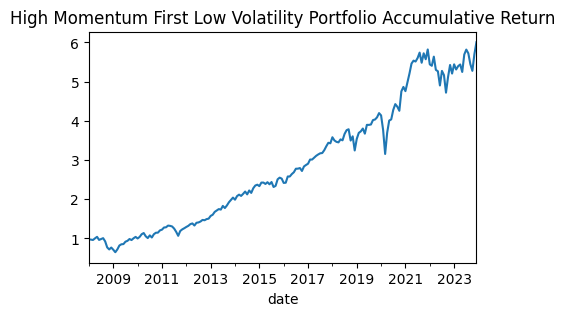

In [13]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_high_momentumFirst_low_volatility).cumprod()
print("Total return of the high momentum first low volatility portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the high momentum first low volatility portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_high_momentumFirst_low_volatility.std() * np.sqrt(12)
print("The annualized volatility of the high momentum first low volatility portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_high_momentumFirst_low_volatility.mean() / equal_weight_portfolio_high_momentumFirst_low_volatility.std() * np.sqrt(12)
print("The Sharpe ratio of the high momentum first low volatility portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_high_momentumFirst_low_volatility.quantile(0.05)
print("The VaR of the high momentum first low volatility portfolio is:", VaR)

# Store the results in the results table
results_df.loc['High Momentum First Low Volatility Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['High Momentum First Low Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['High Momentum First Low Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['High Momentum First Low Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['High Momentum First Low Volatility Portfolio', 'VaR'] = VaR

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='High Momentum First Low Volatility Portfolio Accumulative Return')


#### 2. High Momentum Stock from Low Volatility Universe

In [14]:
# Firstly selecte the low volatility stocks
LowVolatilityFirst_HighMomentum_df = pd.DataFrame(index = rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
LowVolatilityFirst_HighMomentum_df.iloc[:, :] = np.nan

# Copy the rolling 12 months return dataframe to avoid changing the original dataframe
rolling_12_months_return_df_copy = rolling_12_months_return_df.copy()

N_low_volatility = len(tickers) // 2
low_volatility_mask =rolling_12_months_return_df_copy.rank(axis=1, method='dense', ascending=True) <= N_low_volatility

LowVolatilityFirst_HighMomentum_df[low_volatility_mask] = 1
# Set the high momentum stocks to be nan so that we can only select the low volatility stocks
rolling_12_months_return_df_copy[~low_volatility_mask] = np.nan

N_high_momentum = N_low_volatility // 2
# only select the high momentum stocks from the low volatility stocks
high_momentum_mask = rolling_12_months_return_df_copy.rank(axis=1, method='dense', ascending=False) <= N_high_momentum
LowVolatilityFirst_HighMomentum_df[high_momentum_mask] = 1
LowVolatilityFirst_HighMomentum_df[~high_momentum_mask] = np.nan

# Copy the next_intra_month_return_df to avoid changing the original dataframe
next_intra_month_return_df_copy = next_intra_month_return_df.copy()

returns_df_for_low_volatilityFirst_high_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_low_volatilityFirst_high_momentum.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the low volatility first high momentum portfolio
returns_df_for_low_volatilityFirst_high_momentum = next_intra_month_return_df_copy*LowVolatilityFirst_HighMomentum_df

# Get the equal weighted portfolio
equal_weight_portfolio_low_volatilityFirst_high_momentum = returns_df_for_low_volatilityFirst_high_momentum.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_low_volatilityFirst_high_momentum.tail(5))


date
2023-08   -0.025596
2023-09   -0.052451
2023-10   -0.028387
2023-11    0.077703
2023-12     0.05997
Freq: M, dtype: object


Total return of the low volatility first high momentum portfolio is: 7.297453978086025
The annualized return of the low volatility first high momentum portfolio is: 0.1416809582538856
The annualized volatility of the low volatility first high momentum portfolio is: 0.1709408309230835
The Sharpe ratio of the low volatility first high momentum portfolio is: 0.8195338904209629
The VaR of the low volatility first high momentum portfolio is: -0.07433242312469168


<Axes: title={'center': 'Low Volatility First High Momentum Portfolio Accumulative Return'}, xlabel='date'>

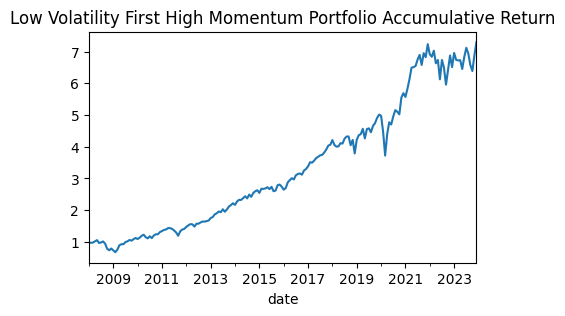

In [15]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_low_volatilityFirst_high_momentum).cumprod()
print("Total return of the low volatility first high momentum portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the low volatility first high momentum portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_low_volatilityFirst_high_momentum.std() * np.sqrt(12)
print("The annualized volatility of the low volatility first high momentum portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_low_volatilityFirst_high_momentum.mean() / equal_weight_portfolio_low_volatilityFirst_high_momentum.std() * np.sqrt(12)
print("The Sharpe ratio of the low volatility first high momentum portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_low_volatilityFirst_high_momentum.quantile(0.05)
print("The VaR of the low volatility first high momentum portfolio is:", VaR)

# Store the results in the results table
results_df.loc['Low Volatility First High Momentum Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['Low Volatility First High Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Low Volatility First High Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Low Volatility First High Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Low Volatility First High Momentum Portfolio', 'VaR'] = VaR

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='Low Volatility First High Momentum Portfolio Accumulative Return')


# Resulte Analysis

In [16]:
results_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,VaR
High Momentum Portfolio,6.619424,0.125385,0.169165,0.741201,-0.080844
Low Volatility Portfolio,5.254435,0.116953,0.151398,0.767549,-0.067171
High Momentum First Low Volatility Portfolio,6.005266,0.126944,0.164762,0.769371,-0.073966
Low Volatility First High Momentum Portfolio,7.297454,0.141681,0.170941,0.819534,-0.074332


From the table above:
- the Low Volatility First High Momentum Portfolio appears to have the best overall performance, with the highest returns, Sharpe Ratio, and relatively lower risk as measured by annualized volatility and VaR.
- Compared to pure-play high momentum portfolio, the 2 combined portfolio both has higher Sharpe ratio. 
- Compared to the pure-play high mometum portfolio, the Low Volatility First High Momentum Portfolio has higher total return but smaller VaR. 